In [1]:
import itertools
import os.path as op
from glob import glob
from time import time

import numpy as np
import pandas as pd

pd.options.display.max_rows = 999
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.stats as stats

# Definitions

In [ ]:
print(
    type(np.ma.asanyarray(nib.load(halo_roif).dataobj)),
    type(np.asanyarray(nib.load(halo_roif).dataobj)),
)

<class 'numpy.ma.core.MaskedArray'> <class 'numpy.memmap'>


In [150]:
halo_roi = nib.load(halo_roif)

In [ ]:
def toggle_gzip(infile):
    """Toggle file string gzipping."""
    if infile.endswith(".gz"):
        return infile[:-3]
    else:
        return infile + ".gz"


def nii2arr(infile, conv_nan=True, dtype=None):
    """Load nifti file as a numpy array."""
    if not op.exists(infile):
        infile = toggle_gzip(infile)

    arr = np.asanyarray(nib.load(infile).dataobj)

    if conv_nan:
        arr[np.isnan(arr)] = 0

    if dtype:
        arr = arr.astype(dtype)

    return arr


def make_suvr(pet, rr_idx, copy=False):
    """Return PET SUVR."""
    if isinstance(rr_idx, str):
        rr_idx = nii2arr()

    if copy:
        suvr = pet.copy()
    else:
        suvr = pet
    suvr /= np.mean(suvr[rr_idx])
    return suvr


def vox_mean(pet, roi_idx):
    """Return the mean pet value within selected voxels."""
    return np.mean(pet[roi_idx])


def get_halo_thresh(pet, halo_idx, thresh=2):
    """Calculate the halo threshold."""
    halo_thresh = np.mean(pet[halo_idx]) + (np.std(pet[halo_idx]) * thresh)
    return halo_thresh


def get_missing_roi(pet, affine, header, outfile, overwrite=False, verbose=False):
    """Save the missing voxels nifti image."""
    # Save a nifti image for the missing voxels.
    missing_roi = np.zeros(pet.shape, dtype=np.byte)

    # Ref. region missing = 1
    idx = np.all((ref_region > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 1

    # Cortical amyloid region missing = 2
    idx = np.all((ctx_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 2

    # Remaining brain missing = 3
    idx = np.all((wb_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 3

    # Save the file as a new image.
    if overwrite or not op.exists(outfile):
        newimg = nib.Nifti1Image(
            missing_roi, pet_img.affine, pet_img.header, dtype=missing_roi.dtype
        )
        newimg.to_filename(outfile)
        if verbose:
            print("Saved {}".format(outfile))

    return missing_roi

# Make halo ROI

In [4]:
# Create the halo ROI.
# passband = [0.01, 0.1]
passband = [0.01, 0.15]
zcutoff = 4
roi_dir = "/Users/dschonhaut/Box/projects/ideas/halo_roi"
infile = op.join(roi_dir, "s12rc1-5_mask_fixed.nii")
outfile = op.join(roi_dir, "halo_roi_thr01-15.nii")
overwrite = True
# ---------------------

# Load the image.
img = nib.load(infile)
dat = np.asanyarray(img.dataobj)

# Initialize the mask.
mask = np.zeros(img.shape, dtype=np.byte)

# Mask voxels within the smoothing passband.
idx = np.all([dat >= passband[0], dat < passband[1]], axis=0)
mask[idx] = True

# Remove mask voxels below the cutoff axial slice.
mask[:, :, :zcutoff] = False

# Save the file as a new image.
if overwrite or not op.exists(outfile):
    newimg = nib.Nifti1Image(mask, img.affine, img.header, dtype=mask.dtype)
    # newimg.to_filename(outfile)
    # print("Saved {}".format(outfile))

# Analyze missing data

In [9]:
# Load ROIs.
box_dir = "/Users/dschonhaut/Box"
data_dir = op.join(box_dir, "projects", "ideas", "data")
pet_dir = op.join(data_dir, "all_niftis")
roi_dir = op.join(data_dir, "ROIs_rPOP")
missingvox_dir = op.join(data_dir, "missing_voxels")
ref_regionf = op.join(roi_dir, "wc_voi_bin.nii")
ctx_roif = op.join(roi_dir, "ctx_voi_bin.nii")
halo_roif = op.join(roi_dir, "halo_roi.nii")
wb_roif = op.join(roi_dir, "rc1-2-thr25-mask.nii")
# ----------------------------

# # Find PET files.
# pet_files = glob(op.join(pet_dir, "w*.nii"))
# print('Found {} warped PET means'.format(len(pet_files)))

# Load ROIs.
halo_roi = nii2arr(halo_roif)
ref_region = nii2arr(ref_regionf)
ctx_roi = nii2arr(ctx_roif)
wb_roi = nii2arr(wb_roif)

halo_idx = np.where(halo_roi)
rr_idx = np.where(ref_region)
ctx_idx = np.where(ctx_roi)
wb_idx = np.where(wb_roi)

halo_gt0 = halo_roi > 0
rr_gt0 = ref_region > 0
ctx_gt0 = ctx_roi > 0
wb_gt0 = wb_roi > 0

# Get the default affine and header info.
_affine = nib.load(ref_regionf).affine
_hdr = nib.load(ref_regionf).header

In [14]:
# Load the IDEAS QC spreadsheet.
ideas_qcf = op.join(
    "/Users/dschonhaut/Box/IDEAS_QC_FINAL/Date_2022-11-08",
    "IDEAS_paths_ratings_N10700.xlsx",
)
browse_cols = ["QC_rating", "Consensus_rating", "Fail_Subcategory"]
keep_cols = ["qc_cat", "wmeanf", "QC_rating", "Consensus_rating", "Fail_Subcategory"]
# -----------------------

# Load the QC scan spreadsheet.
ideas_qc = pd.read_excel(ideas_qcf)
assert len(ideas_qc) == ideas_qc["ID"].nunique()
ideas_qc.set_index("ID", inplace=True)

# Group scans by QC category.
qc_cats = pd.Series(
    {
        "pass": ideas_qc.query("(QC_rating=='Pass-Pass') | (Consensus_rating=='Pass')")
        .index.unique()
        .tolist(),
        "fail_anatomical": ideas_qc.query("(Fail_Subcategory=='Anatomical')")
        .index.unique()
        .tolist(),
        "fail_fovref": ideas_qc.query("(Fail_Subcategory=='FOV-Ref')")
        .index.unique()
        .tolist(),
    }
)
for cat1, cat2 in itertools.combinations(qc_cats.index, 2):
    assert len(set(qc_cats[cat1]) & set(qc_cats[cat2])) == 0
ideas_qc.insert(0, "qc_cat", np.nan)
for qc_cat, subjs in qc_cats.items():
    ideas_qc.loc[np.isin(ideas_qc.index, subjs), "qc_cat"] = qc_cat
qc_idx = ideas_qc["qc_cat"].dropna().index

# Add paths to the warped mean images.
assert (
    ideas_qc["path_to_warpednii_Qced"]
    .apply(lambda x: op.exists(op.join(pet_dir, op.basename(x))))
    .all()
)
ideas_qc.insert(
    1,
    "wmeanf",
    ideas_qc["path_to_warpednii_Qced"].apply(
        lambda x: op.join(pet_dir, op.basename(x))
    ),
)
ideas_qc = ideas_qc.loc[:, keep_cols]

# Print some basic info
print("ideas_qc: {}".format(ideas_qc.shape))
print("scans with qc_cat: {}".format(qc_idx.size))
print("")
for col in browse_cols:
    print(ideas_qc.groupby(col).size(), end="\n" * 2)
for k in qc_cats.index:
    print("{:>4} {} scans".format(len(qc_cats[k]), k))
print("")
display(ideas_qc.iloc[np.r_[0:5, -5:0], :])

ideas_qc: (10700, 5)
scans with qc_cat: 10214

QC_rating
Consensus-Consensus     113
Consensus-Fail           71
Consensus-Pass          541
Fail-Consensus           70
Fail-Fail               481
Fail-Pass               134
Pass-Consensus          326
Pass-Fail                69
Pass-Pass              8895
dtype: int64

Consensus_rating
Consensus     13
Fail         860
Pass         932
dtype: int64

Fail_Subcategory
Acquisition    192
Anatomical     267
FOV-ROI          2
FOV-Ref        120
Other           40
Warping        239
dtype: int64

9827 pass scans
 267 fail_anatomical scans
 120 fail_fovref scans



,qc_cat,wmeanf,QC_rating,Consensus_rating,Fail_Subcategory
ID,,,,,
50001,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Consensus-Pass,Pass,NaN
50002,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
50003,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
50004,NaN,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Consensus,Fail,Other
50005,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
64677,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
64678,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
64679,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN
64680,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN


In [51]:
start = time()
new_cols = [
    "halo_thresh",
    "ctx_suvr",
    "wb_suvr",
    "rr_missing",
    "ctx_missing",
    "wb_missing",
]
save_missing_img = False
overwrite = False
verbose = False
# -----------------------------

for col in new_cols:
    ideas_qc[col] = np.nan

for subj in qc_idx:
    petf = ideas_qc.at[subj, "wmeanf"]
    suvr = make_suvr(nii2arr(petf, dtype=np.float32), rr_idx)

    ideas_qc.at[subj, "halo_thresh"] = get_halo_thresh(suvr, halo_idx, 2)
    ideas_qc.at[subj, "ctx_suvr"] = vox_mean(suvr, ctx_idx)
    ideas_qc.at[subj, "wb_suvr"] = vox_mean(suvr, wb_idx)

    suvr_lt_thresh = suvr < ideas_qc.at[subj, "halo_thresh"]
    ideas_qc.at[subj, "rr_missing"] = (
        np.count_nonzero(np.all((rr_gt0, suvr_lt_thresh), axis=0)) / rr_idx[0].size
    )
    ideas_qc.at[subj, "ctx_missing"] = (
        np.count_nonzero(np.all((ctx_gt0, suvr_lt_thresh), axis=0)) / ctx_idx[0].size
    )
    ideas_qc.at[subj, "wb_missing"] = (
        np.count_nonzero(np.all((wb_gt0, suvr_lt_thresh), axis=0)) / wb_idx[0].size
    )

    if save_missing_img:
        missing_roif = op.join(missingvox_dir, "w{}_missing-voxels.nii".format(subj))
        missing_roi = get_missing_roi(
            suvr, _affine, _hdr, missing_roif, overwrite=overwrite, verbose=verbose
        )

print("Done in {:.2f}s".format(time() - start))

Done in 315.46s


In [61]:
# Save/load the updated QC dataframe.
overwrite = False
# ------------------------

ideas_qc_outf = op.join(data_dir, "ideas_qc.csv")
if overwrite or not op.exists(ideas_qc_outf):
    ideas_qc.to_csv(ideas_qc_outf)
    print("Saved {}".format(ideas_qc_outf))
else:
    ideas_qc = pd.read_csv(ideas_qc_outf)
    ideas_qc.set_index("ID", inplace=True)
    assert ideas_qc.index.nunique() == len(ideas_qc)
    print("Loaded ideas_qc, shape: {}".format(ideas_qc.shape))

Saved /Users/dschonhaut/Box/projects/ideas/data/ideas_qc.csv


In [32]:
ideas_qc.head()

,qc_cat,wmeanf,QC_rating,Consensus_rating,Fail_Subcategory,halo_thresh,ctx_suvr,wb_suvr,rr_missing,ctx_missing,wb_missing
ID,,,,,,,,,,,
50001,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Consensus-Pass,Pass,NaN,0.042330,0.729011,0.873379,0.0,0.0,0.000535
50002,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN,0.055853,1.323197,1.160417,0.0,0.0,0.000000
50003,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN,0.024506,1.769268,1.472429,0.0,0.0,0.000000
50004,NaN,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Consensus,Fail,Other,NaN,NaN,NaN,NaN,NaN,NaN
50005,pass,/Users/dschonhaut/Box/projects/ideas/data/all_...,Pass-Pass,NaN,NaN,0.031136,1.573251,1.347140,0.0,0.0,0.000000


In [62]:
def mean_ci(x):
    return "{:.3f} (CI={:.3f}-{:.3f}, min={:.3f}, max={:.3f})".format(
        np.mean(x),
        np.mean(x) - (1.96 * stats.sem(x)),
        np.mean(x) + (1.96 * stats.sem(x)),
        np.min(x),
        np.max(x),
    )


(
    ideas_qc.loc[qc_idx, :]
    .groupby("qc_cat")
    .agg(
        {
            "wmeanf": len,
            "halo_thresh": mean_ci,
            "ctx_suvr": mean_ci,
            "wb_suvr": mean_ci,
            "rr_missing": lambda x: mean_ci(x * 100),
            "ctx_missing": lambda x: mean_ci(x * 100),
            "wb_missing": lambda x: mean_ci(x * 100),
        }
    )
)

,wmeanf,halo_thresh,ctx_suvr,wb_suvr,rr_missing,ctx_missing,wb_missing
qc_cat,,,,,,,
fail_anatomical,267,"0.059 (CI=0.053-0.065, min=0.004, max=0.518)","1.304 (CI=1.262-1.346, min=0.701, max=2.771)","1.188 (CI=1.164-1.212, min=0.820, max=2.224)","0.136 (CI=0.003-0.268, min=0.000, max=13.608)","0.049 (CI=-0.011-0.110, min=0.000, max=8.074)","0.156 (CI=0.035-0.276, min=0.000, max=12.708)"
fail_fovref,120,"0.066 (CI=0.058-0.073, min=0.015, max=0.286)","1.376 (CI=1.320-1.432, min=0.905, max=2.328)","1.218 (CI=1.187-1.250, min=0.951, max=1.952)","1.838 (CI=0.965-2.711, min=0.000, max=38.641)","0.002 (CI=-0.001-0.004, min=0.000, max=0.160)","0.553 (CI=0.428-0.678, min=0.045, max=4.912)"
pass,9827,"0.052 (CI=0.051-0.052, min=0.002, max=0.543)","1.354 (CI=1.348-1.360, min=0.701, max=2.518)","1.226 (CI=1.222-1.229, min=0.858, max=1.915)","0.009 (CI=0.004-0.013, min=0.000, max=15.288)","0.001 (CI=0.000-0.001, min=0.000, max=3.171)","0.012 (CI=0.009-0.014, min=0.000, max=9.360)"


In [66]:
# ideas_qc.loc[ideas_qc['qc_cat']=='pass', 'halo_thresh']

In [92]:
import seaborn as sns

co = {
    "red": "#E3120B",
    "blue": "#006BA2",
    "cyan": "#3EBCD2",
    "green": "#379A8B",
    "yellow": "#EBB434",
    "purple": "#9A607F",
    "gray": "#B7C6CF",
    "lgray": "#E9EDF0",
    "dgray": "#758D99",
}

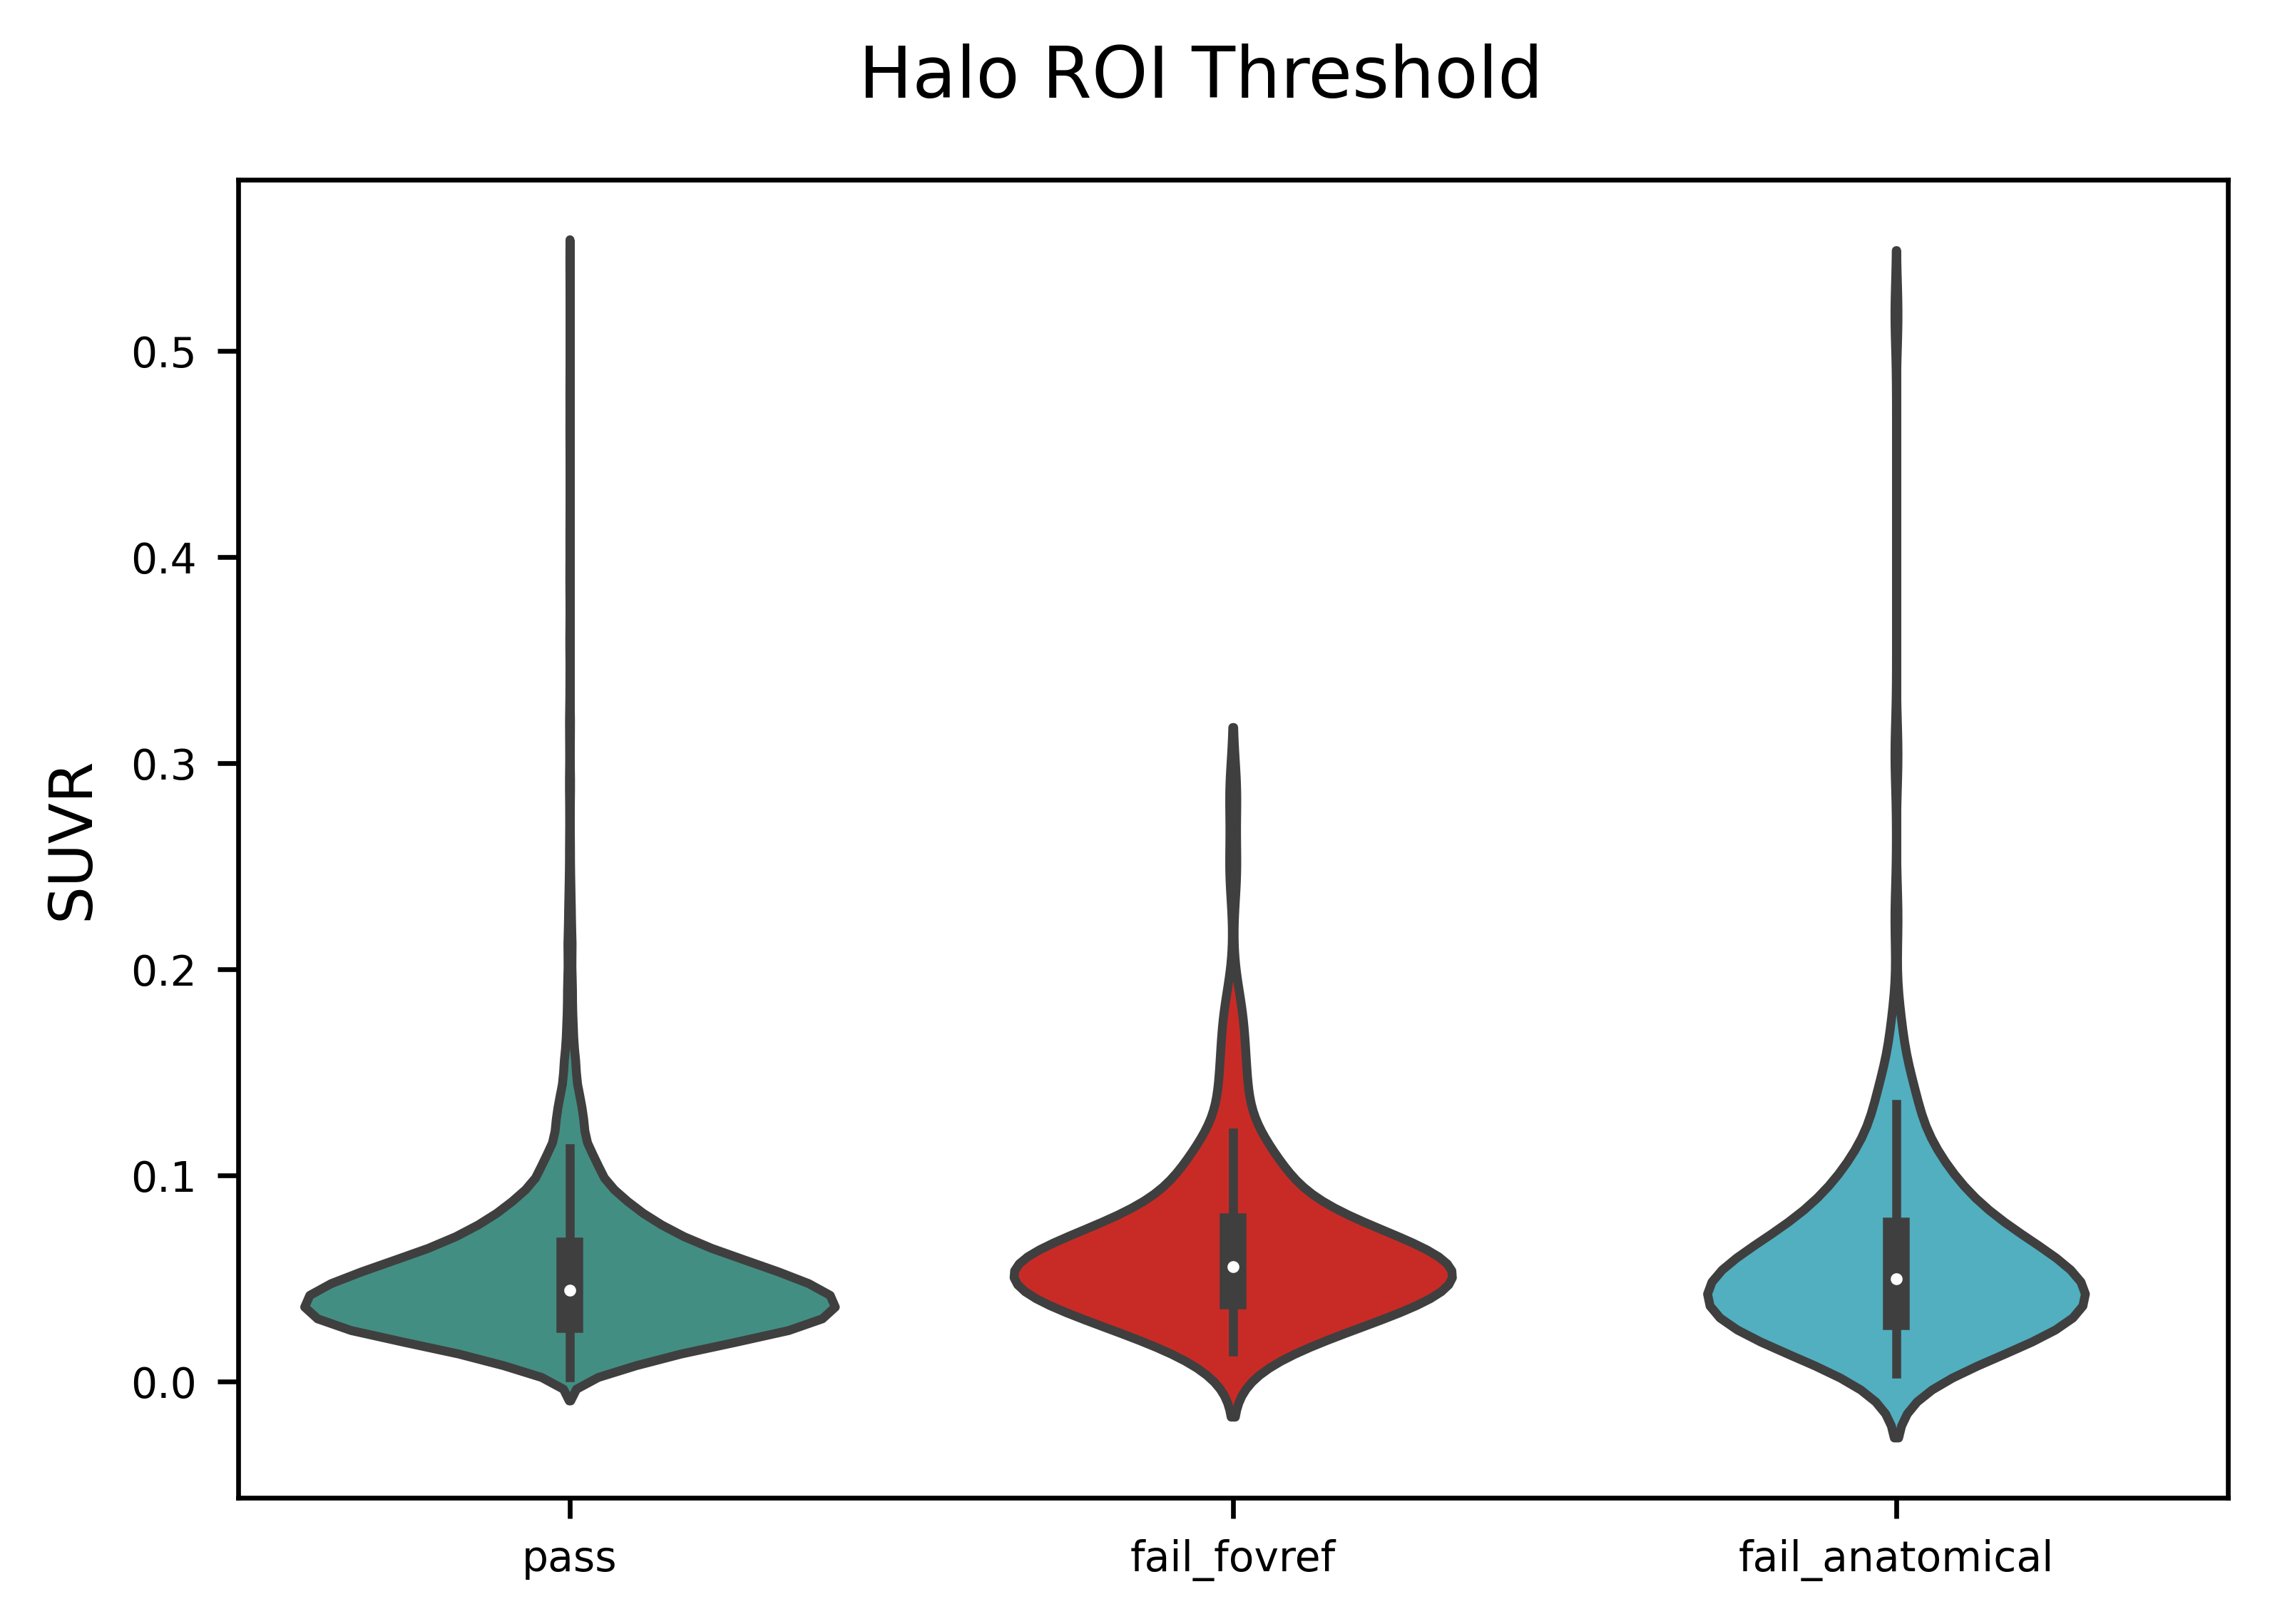

In [106]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="halo_thresh",
    lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("SUVR", labelpad=labelpad)
fig.suptitle("Halo ROI Threshold", y=0.96)

plt.show()

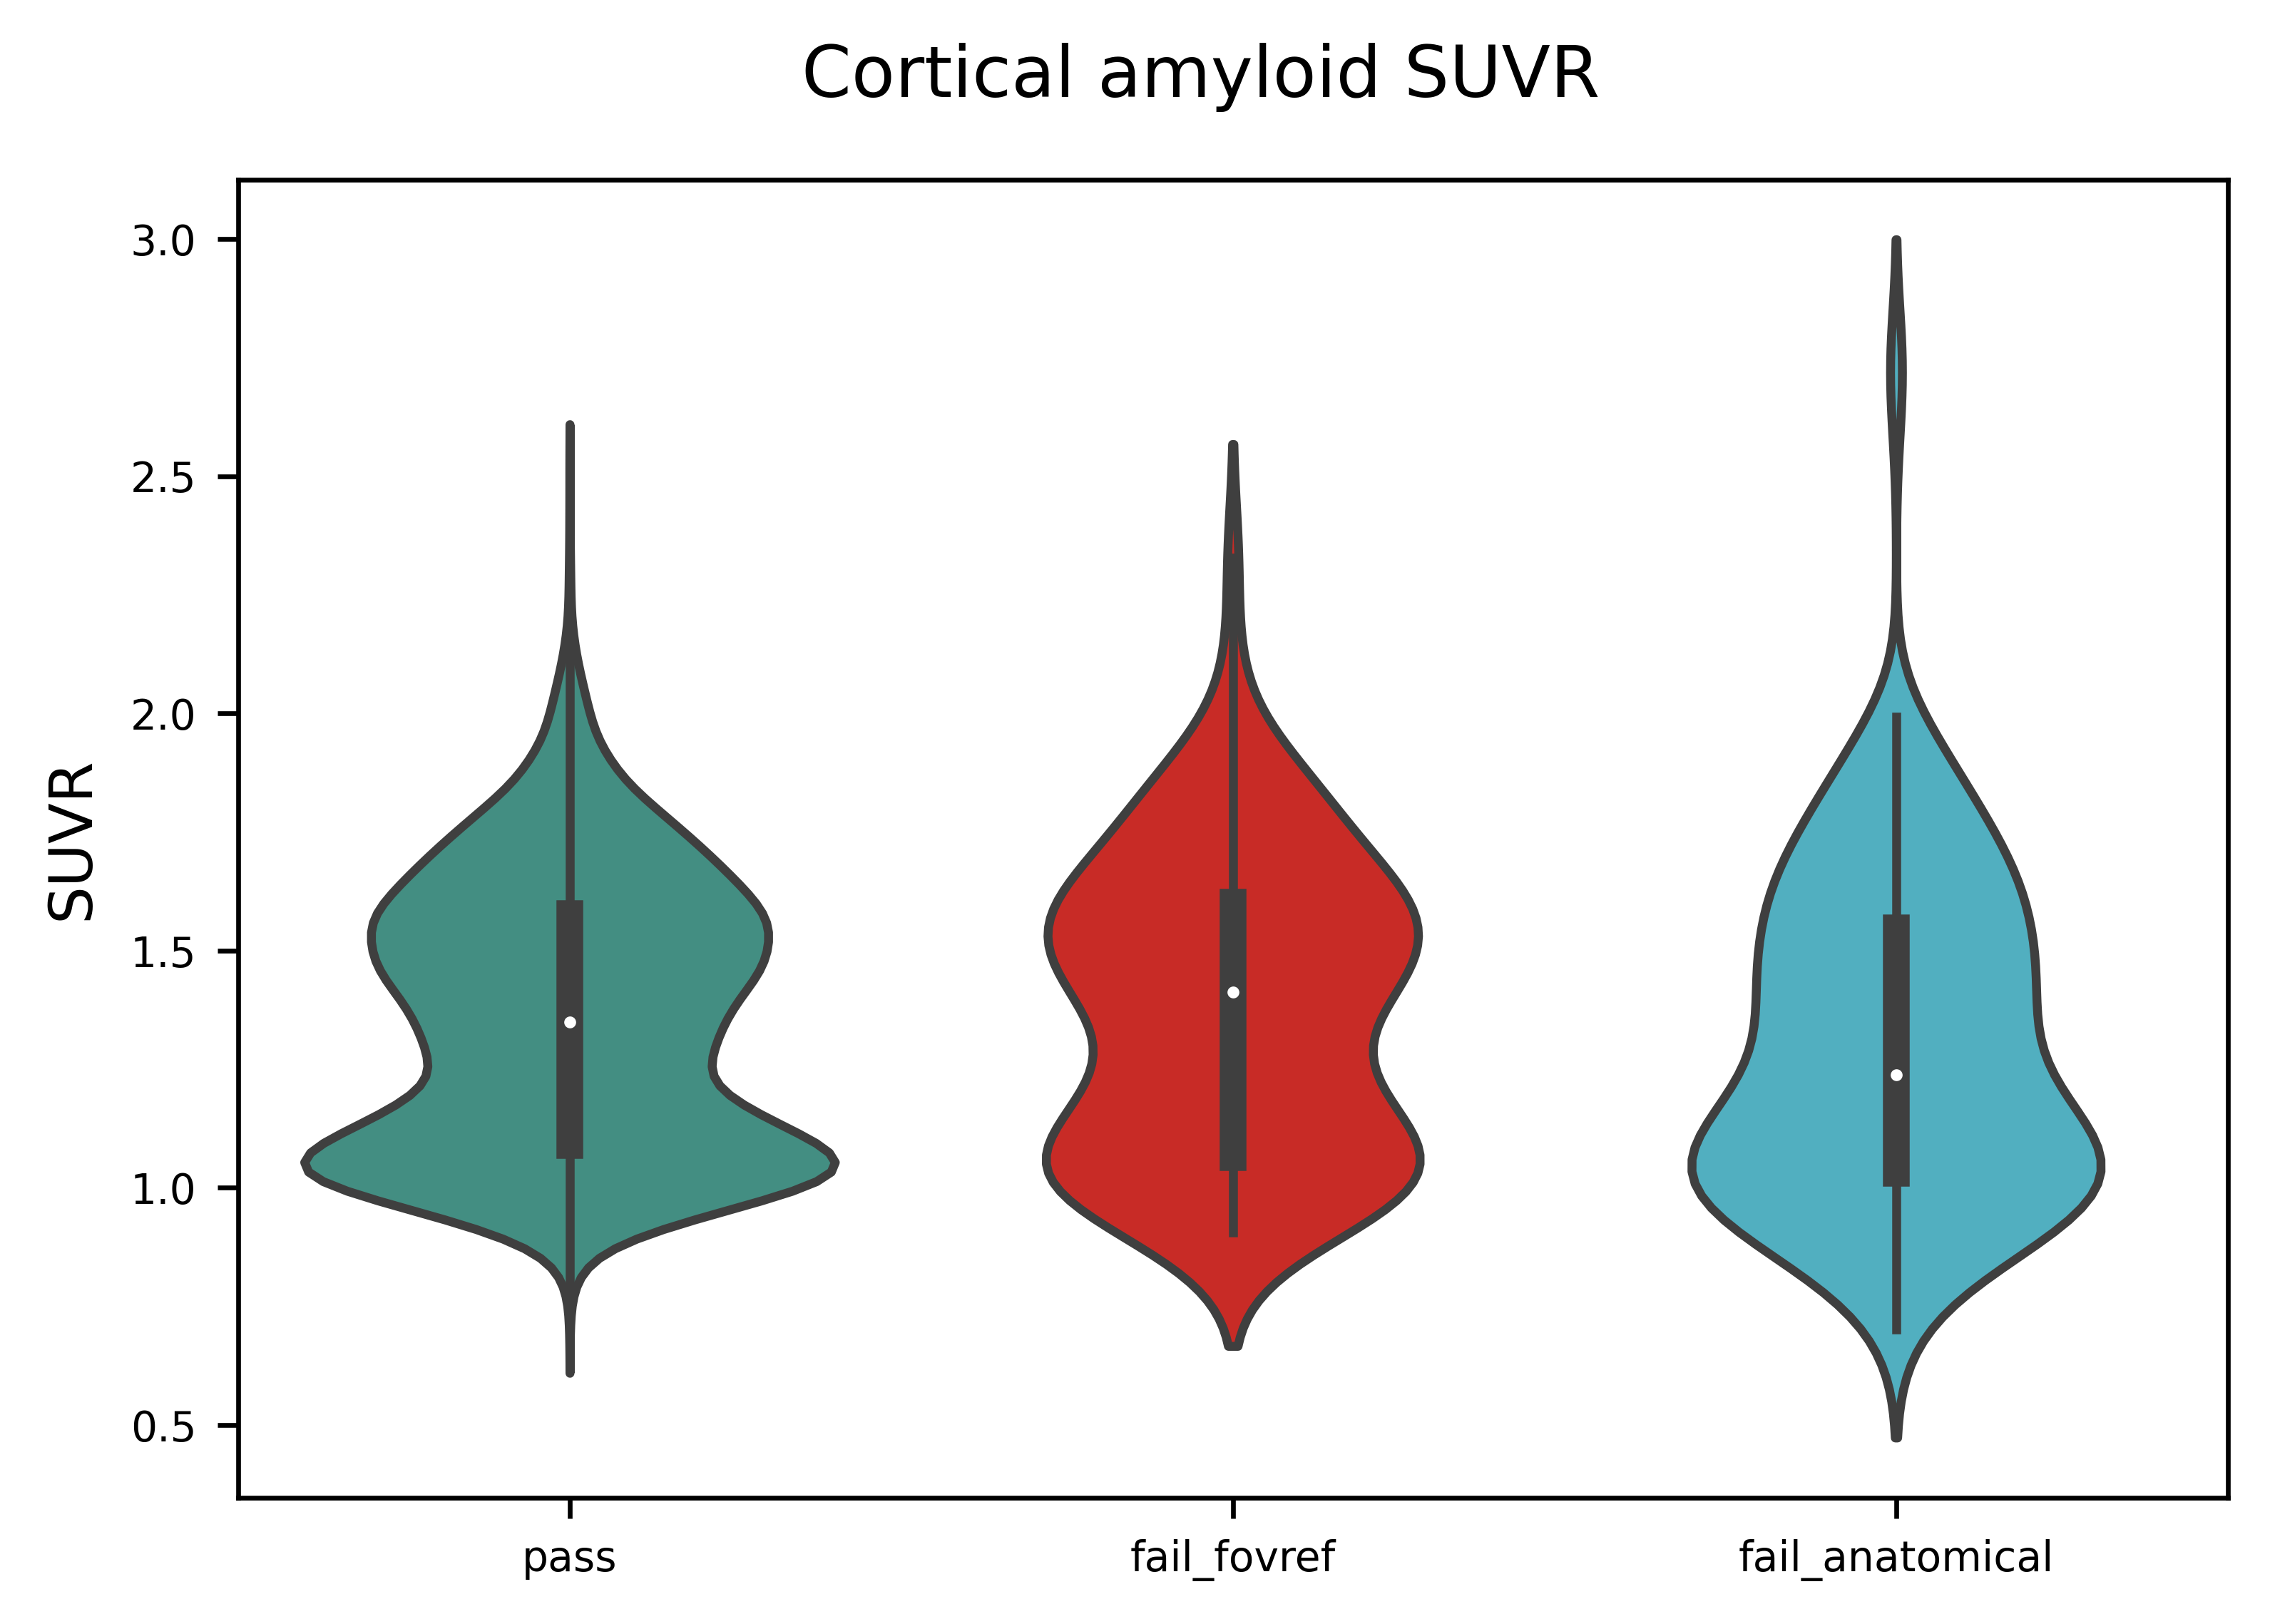

In [105]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="ctx_suvr",
    lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("SUVR", labelpad=labelpad)
fig.suptitle("Cortical amyloid SUVR", y=0.96)

plt.show()

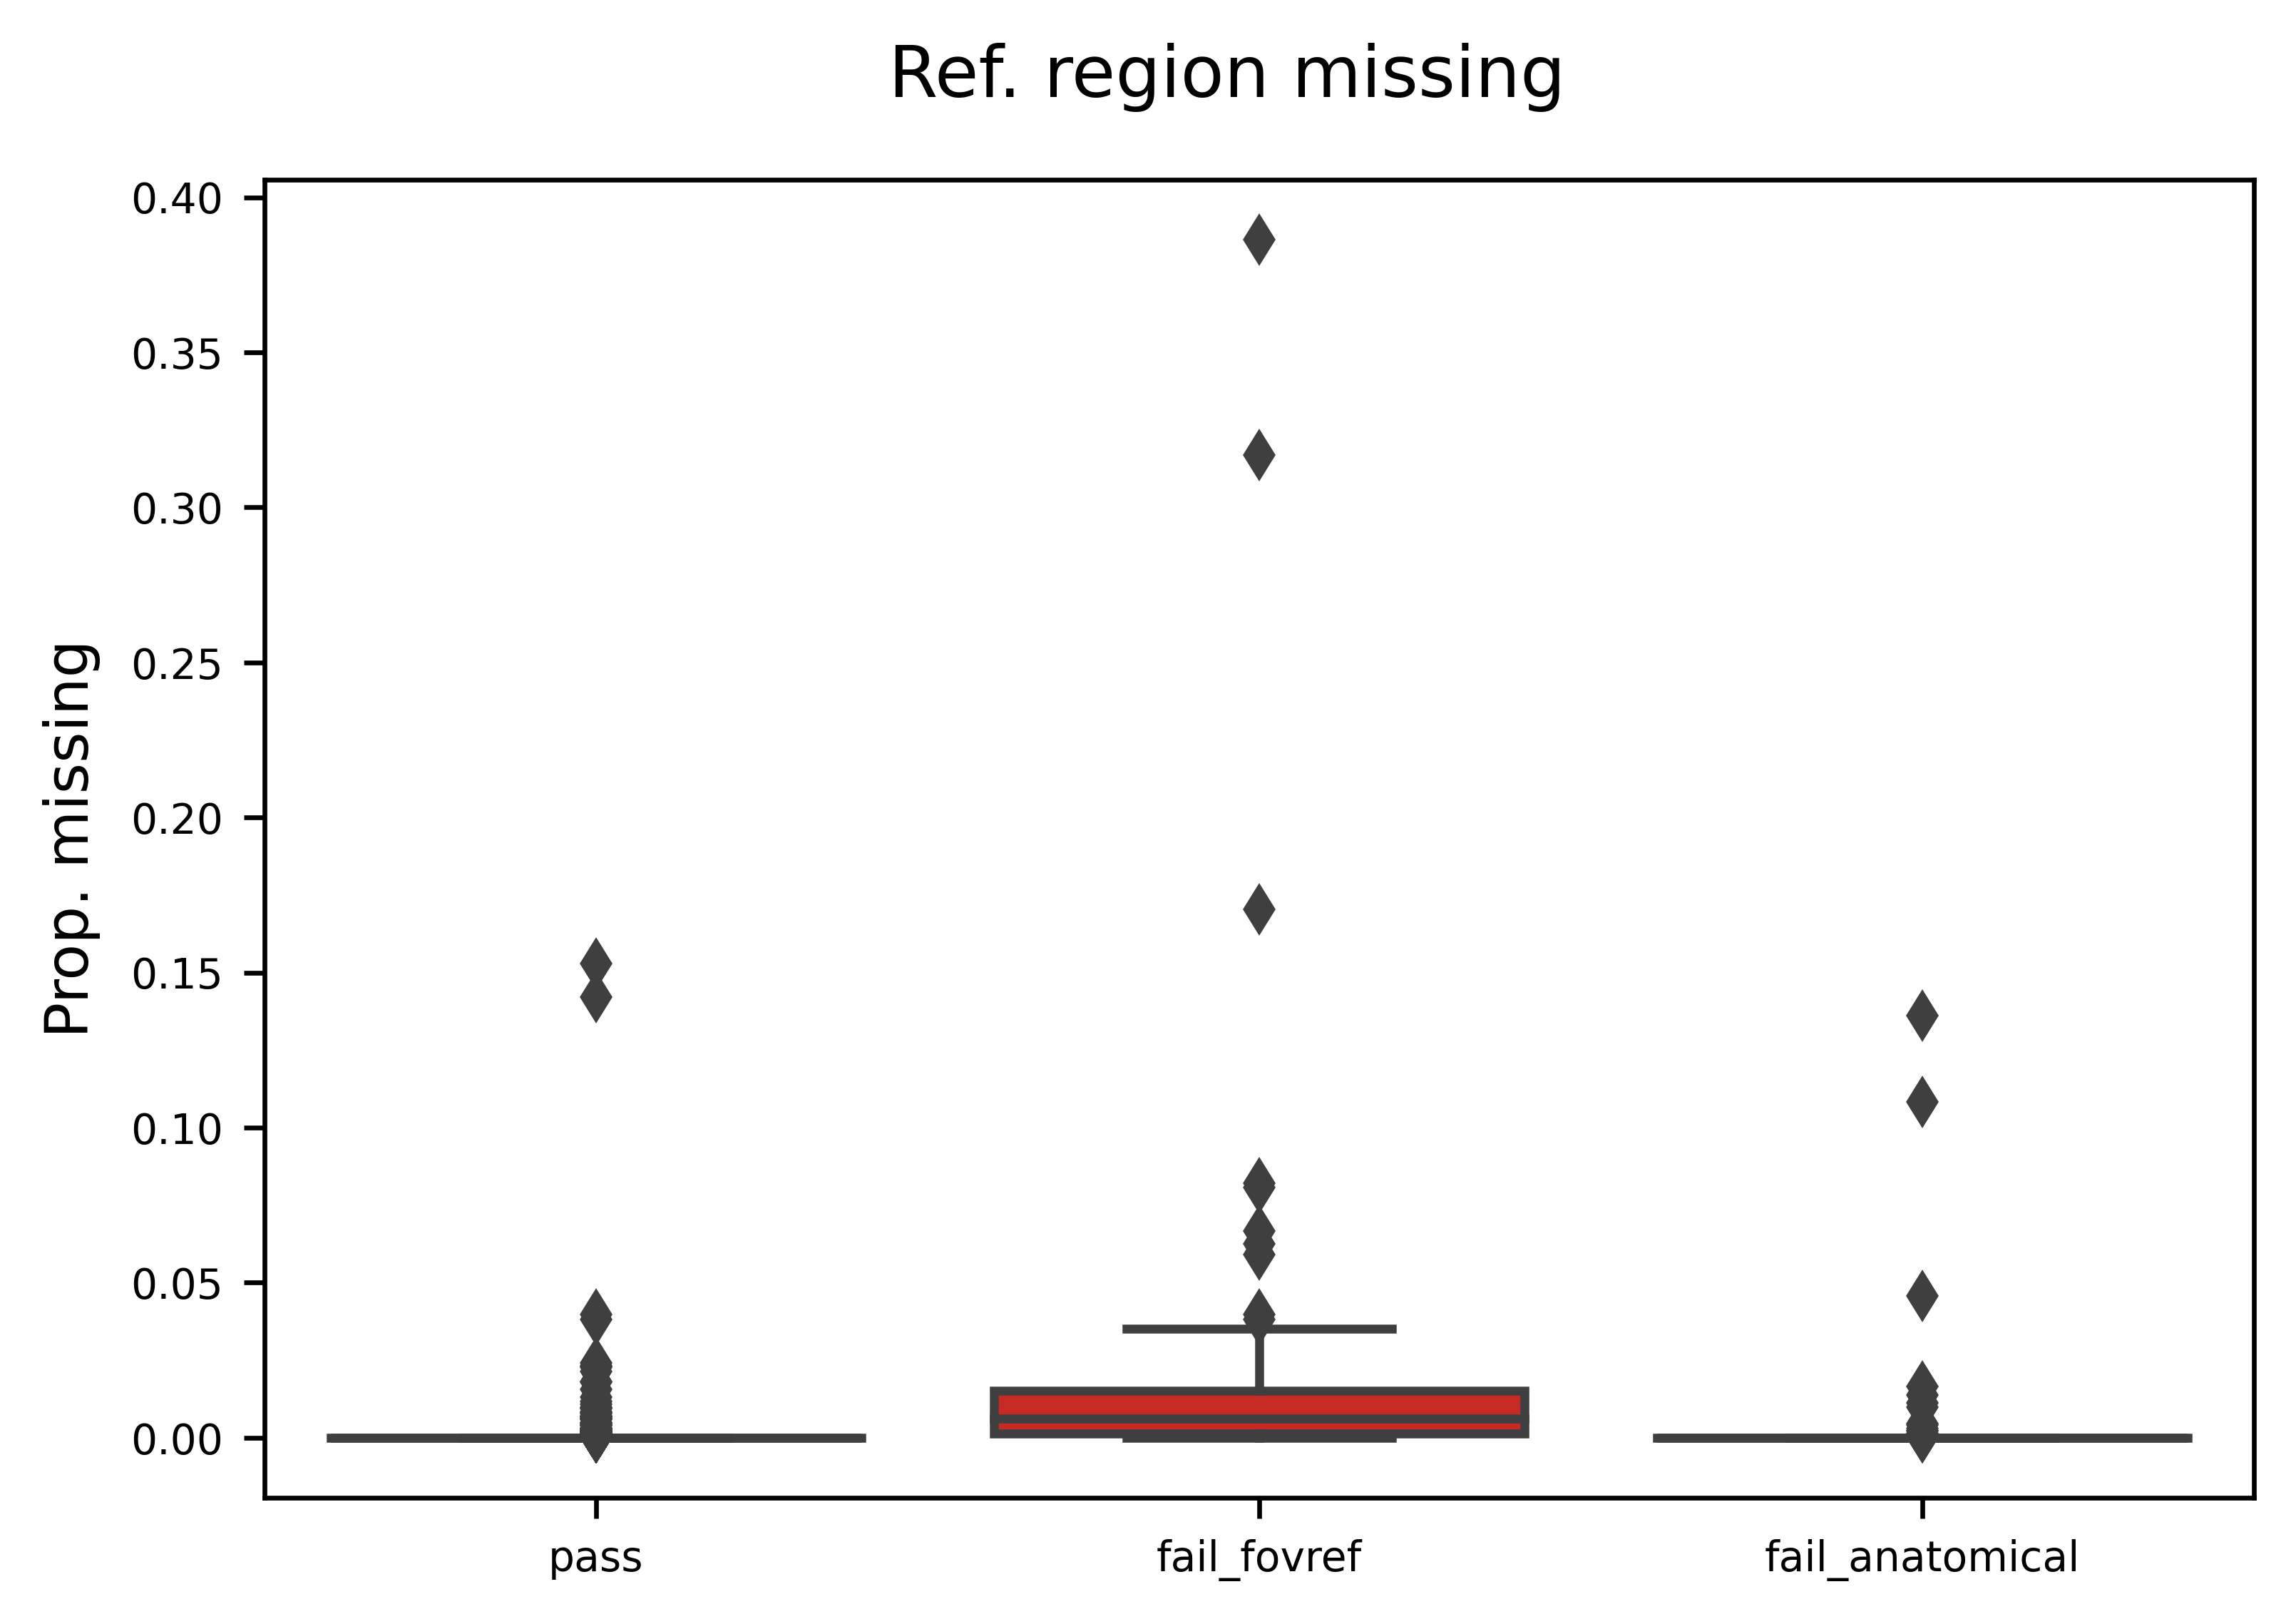

In [118]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.boxplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="rr_missing",  # lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("Prop. missing", labelpad=labelpad)
fig.suptitle("Ref. region missing", y=0.96)

plt.show()

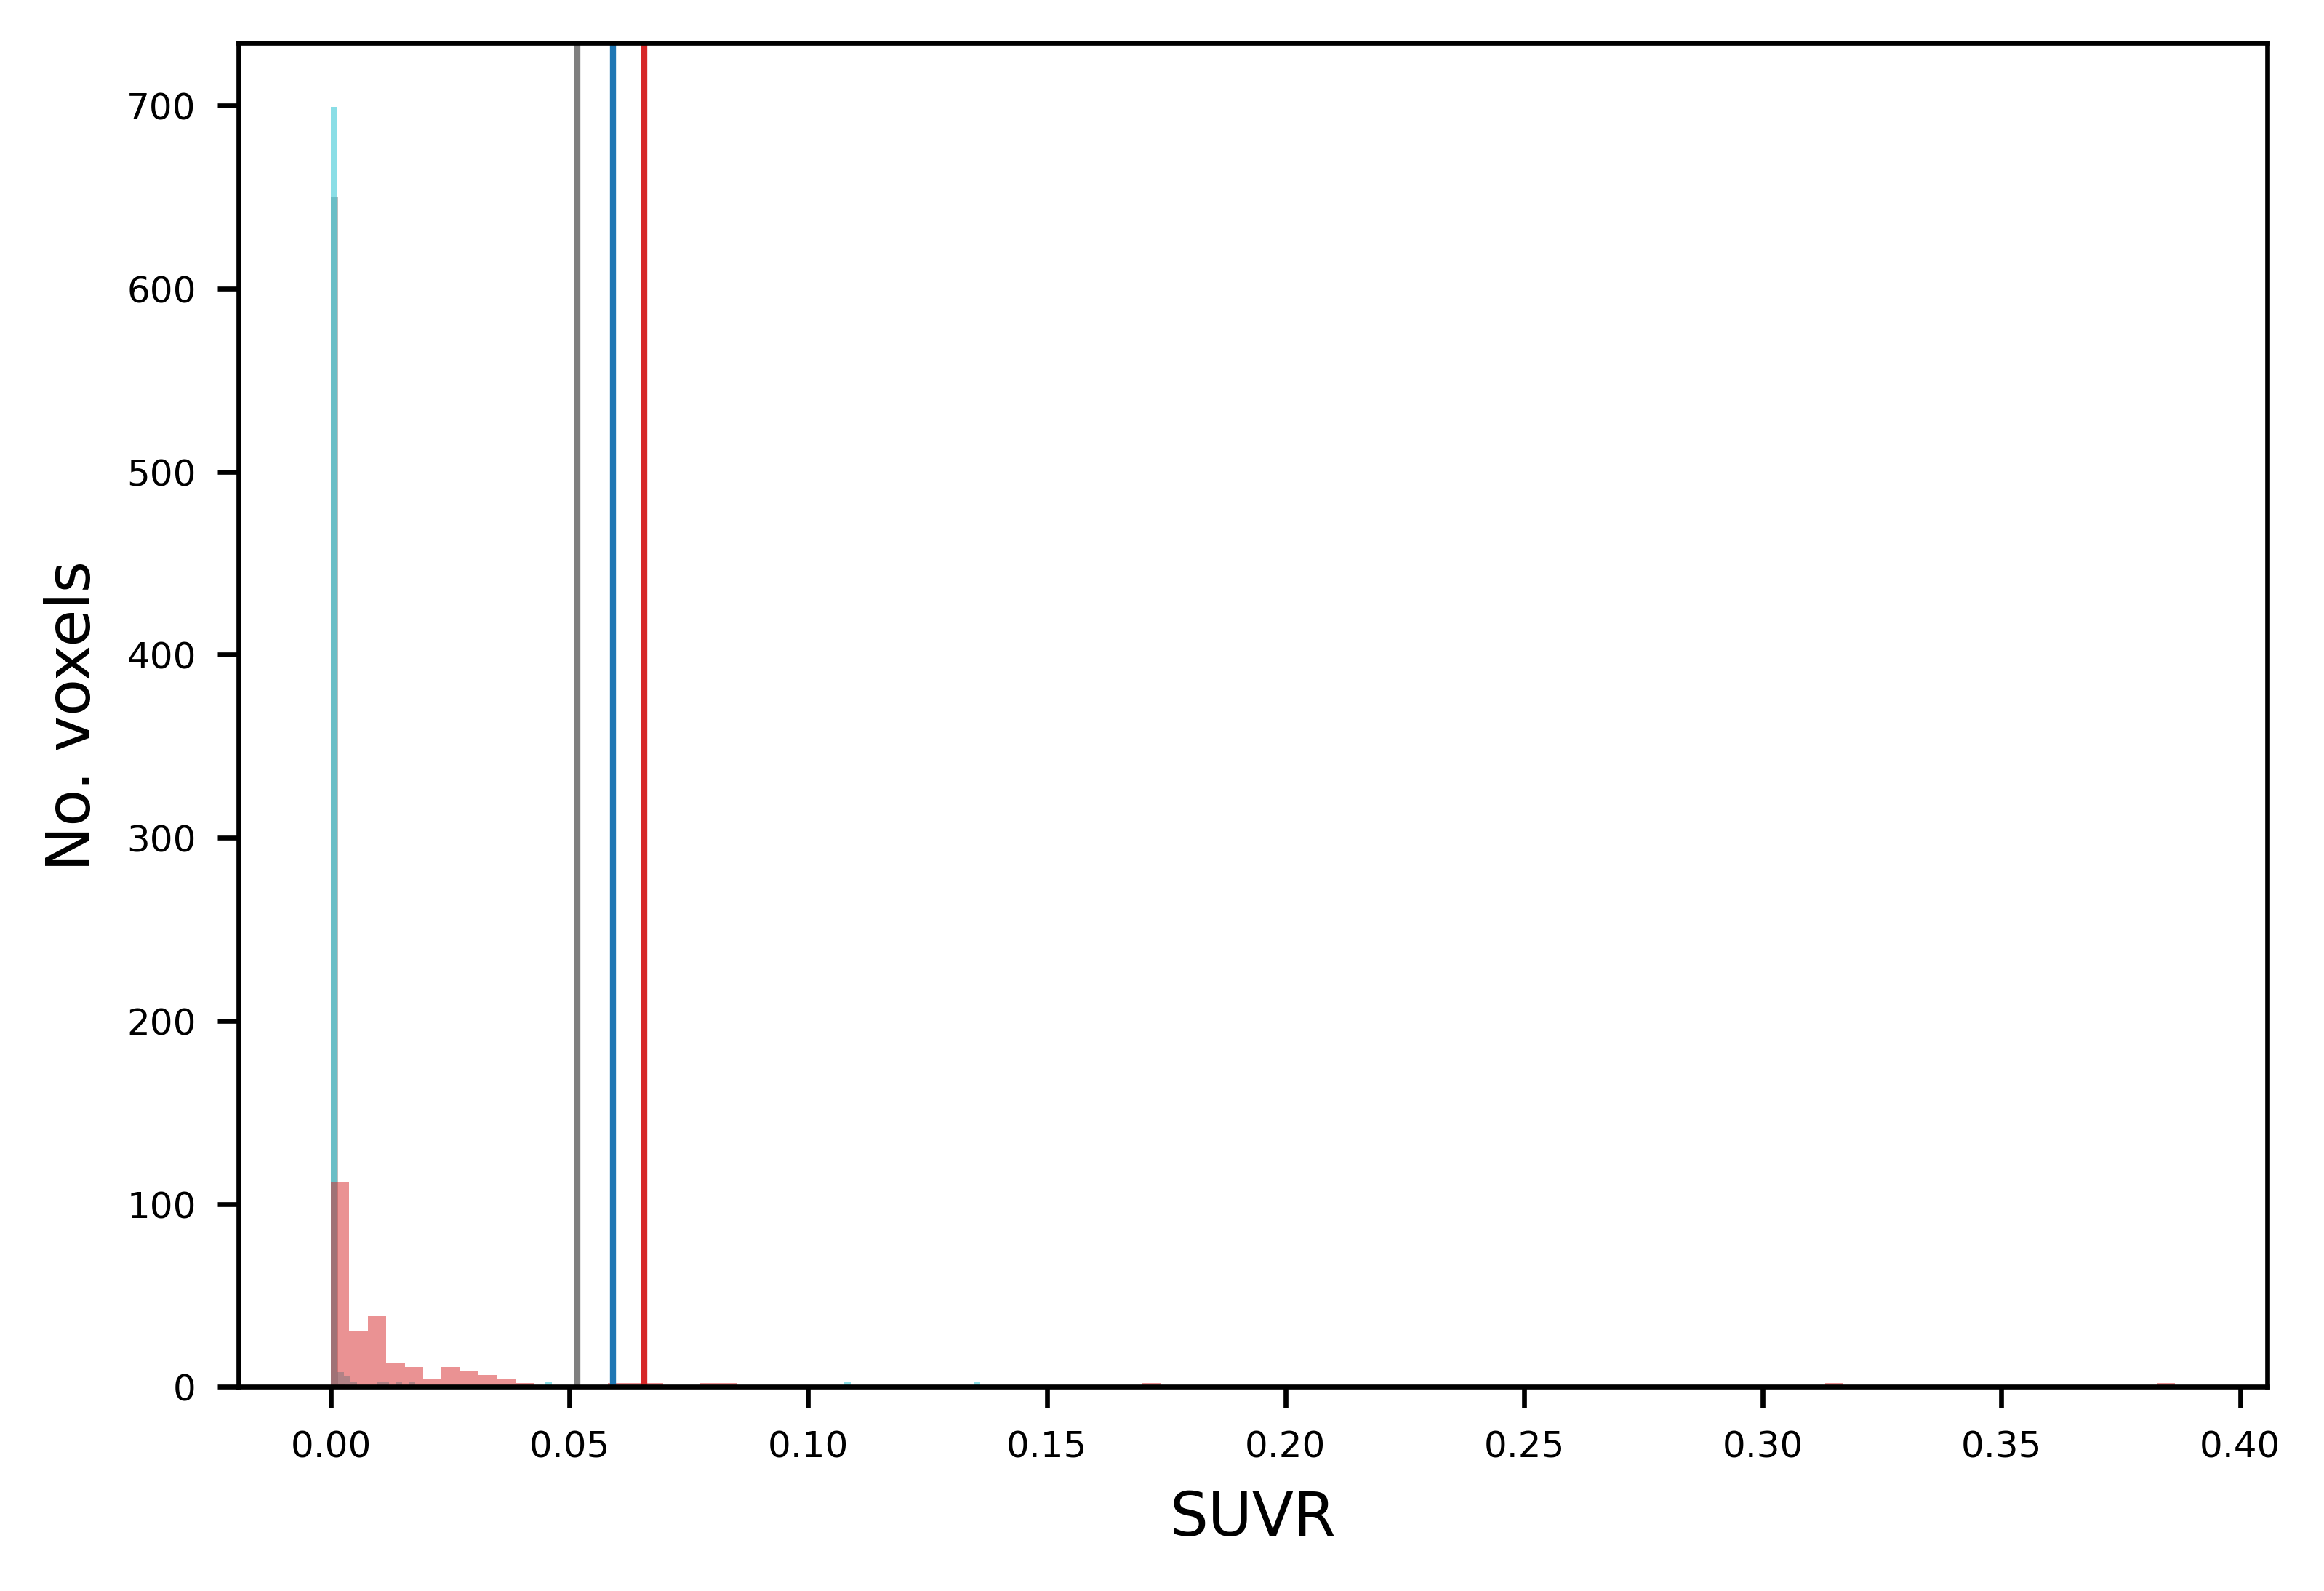

In [110]:
alpha = 0.5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "pass", "rr_missing"],
    bins=100,
    color="tab:gray",
    alpha=alpha,
    density=True,
)
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "fail_anatomical", "rr_missing"],
    bins=100,
    color="tab:cyan",
    alpha=alpha,
    density=True,
)
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "fail_fovref", "rr_missing"],
    bins=100,
    color="tab:red",
    alpha=alpha,
    density=True,
)

_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "pass", "halo_thresh"]),
    color="tab:gray",
    lw=1,
)
_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "fail_anatomical", "halo_thresh"]),
    color="tab:blue",
    lw=1,
)
_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "fail_fovref", "halo_thresh"]),
    color="tab:red",
    lw=1,
)
# _ax.set_yscale('log')
_ax.tick_params(labelsize=6)
_ax.set_xlabel("SUVR")
_ax.set_ylabel("No. voxels")


plt.show()

In [52]:
# Load PET.
subj = 52468
# ---------------------------

petf = ideas_qc.at[subj, "wmeanf"]
suvr = make_suvr(nii2arr(petf), rr_idx)
halo_thresh = get_halo_thresh(suvr, halo_idx, 2)

print("Missing voxel cutoff = {:.3f}".format(halo_thresh))

Missing voxel cutoff = 0.045


In [266]:
outfile = op.join(
    missingvox_dir, op.basename(petf).replace(".nii", "_missing-voxels.nii")
)
overwrite = False
# -------------------------

# Save a nifti image for the missing voxels.
missing_roi = np.zeros(pet.shape, dtype=np.byte)

# Ref. region missing = 1
idx = np.all((ref_region > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 1

# Cortical amyloid region missing = 2
idx = np.all((ctx_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 2

# Remaining brain missing = 3
idx = np.all((wb_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 3

# Save the file as a new image.
if overwrite or not op.exists(missingvox_dir):
    newimg = nib.Nifti1Image(
        missing_roi, pet_img.affine, pet_img.header, dtype=missing_roi.dtype
    )
    newimg.to_filename(outfile)
    print("Saved {}".format(outfile))

Saved /Users/dschonhaut/data/IDEAS_FullAnalysis/missing_voxels/w52468_missing-voxels.nii


Missing voxel cutoff = 0.045
Missing  2,417 (1.17%) voxels in the brain
Missing    882 (5.90%) voxels in the ref. region
Missing      0 (0.00%) voxels in the pos-amyloid ROI


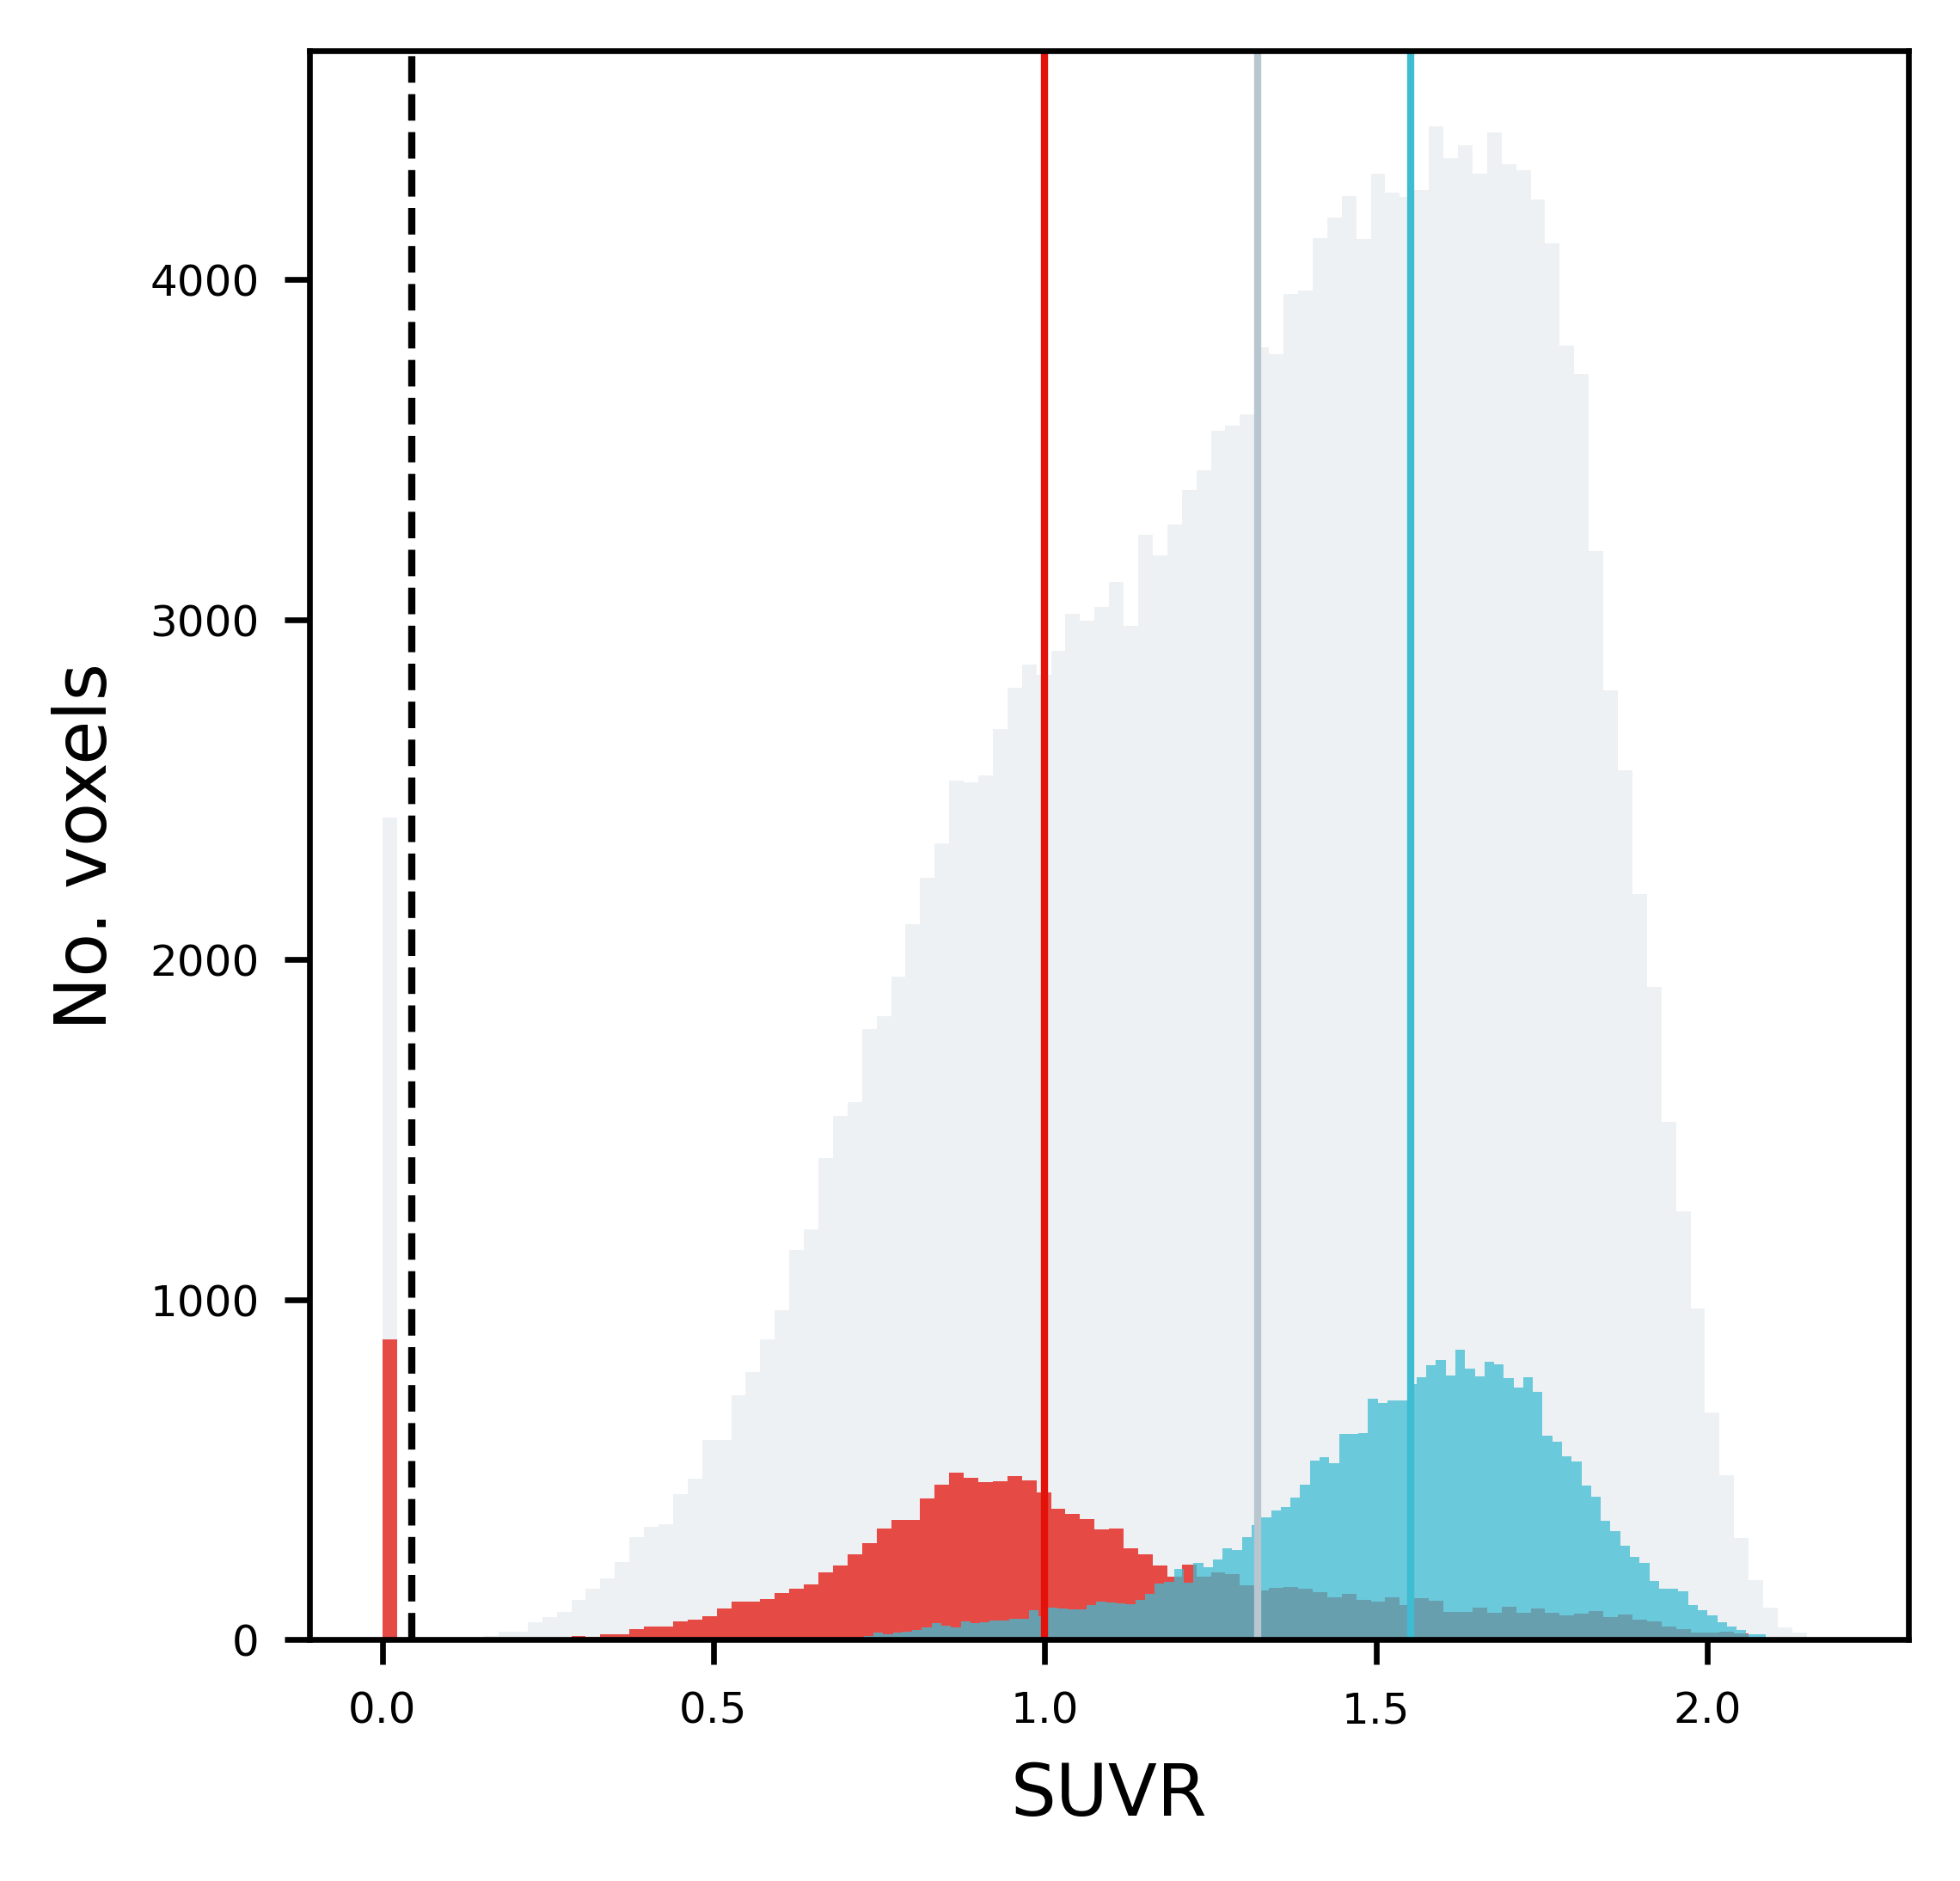

In [112]:
alpha = 0.75
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
# _ax.hist(suvr[halo_idx].ravel(), bins=100, color='tab:gray', alpha=alpha)
_ax.hist(suvr[wb_idx].ravel(), bins=100, color=co["lgray"], alpha=alpha)
_ax.hist(suvr[rr_idx].ravel(), bins=100, color=co["red"], alpha=alpha)
_ax.hist(suvr[ctx_idx].ravel(), bins=100, color=co["cyan"], alpha=alpha)
_ax.axvline(halo_thresh, color="k", linestyle="--", lw=1)
_ax.axvline(np.mean(suvr[wb_idx]), color=co["gray"], lw=1)
_ax.axvline(np.mean(suvr[rr_idx]), color=co["red"], lw=1)
_ax.axvline(np.mean(suvr[ctx_idx]), color=co["cyan"], lw=1)
# _ax.set_yscale('log')
_ax.tick_params(labelsize=6)
_ax.set_xlabel("SUVR")
_ax.set_ylabel("No. voxels")

wb_size = wb_idx[0].size
rr_size = rr_idx[0].size
ctx_size = ctx_idx[0].size

wb_missing = np.count_nonzero(suvr[wb_idx] < halo_thresh)
rr_missing = np.count_nonzero(suvr[rr_idx] < halo_thresh)
ctx_missing = np.count_nonzero(suvr[ctx_idx] < halo_thresh)

print("Missing voxel cutoff = {:.3f}".format(halo_thresh))
print(
    "Missing {:>6,} ({:.2%}) voxels in the brain".format(
        wb_missing, wb_missing / wb_size
    )
)
print(
    "Missing {:>6,} ({:.2%}) voxels in the ref. region".format(
        rr_missing, rr_missing / rr_size
    )
)
print(
    "Missing {:>6,} ({:.2%}) voxels in the pos-amyloid ROI".format(
        ctx_missing, ctx_missing / ctx_size
    )
)
plt.show()

In [ ]:
# Load every PET SUVR and find halo cutoffs and missing voxels.